In [2]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import itertools
import random
import tqdm


from typing import*

from collections import*
# from scipy import*
from sklearn.metrics import*

from numpy import *

# bltin_sum = np.sum

import random

from itertools import cycle
from sklearn import*
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [3]:
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

#     return np.sum(v_i * w_i for v_i, w_i in zip(v, w))
#     gen = 
    return np.sum(np.fromiter((v_i * w_i for v_i, w_i in zip(v, w)),float))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def sigmoid(t: float) -> float: 
    return 1 / (1 + math.exp(-t))

# Gradient Descent - step
def gradient_step(v: Vector, gradient: Vector, step_size: float):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector).
    """
    return not isinstance(tensor[0], list)

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise""" 
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor] 
    
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)


def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]
    
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])


def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]


class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
                
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the
inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

def recolor(pixel):
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

def get_values(cluster):
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]


def cluster_distance(cluster1,
                     cluster2,
                     distance_agg: Callable = min):
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting
list
    """
    return distance_agg([distance(v1, v2) for v1 in get_values(cluster1) for v2 in get_values(cluster2)])

def get_merge_order(cluster):
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order
    
def get_children(cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children
    
class Merged(NamedTuple):
    children: tuple
    order: int

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min):
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair):
        return cluster_distance(pair[0], pair[1], distance_agg)
 
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster,
                      num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [4]:
# # Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target

# # Binarize the output
# y = label_binarize(y, classes=[0, 1, 2])
# n_classes = y.shape[1]

In [5]:
import requests
import csv

rows = []

filename = 'iris.csv'
# reading csv file 
with open(filename, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile) 
#     iris_data = [parse_iris_row(row) for row in csvreader]

# extracting each data row one by one
    for row in csvreader: 
        rows.append(row) 
        
# print(rows)

def parse_iris_row(row):
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = [value.split('-')[-1]for value in row]

    return label

# with open('iris.data') as f:
#     reader = csv.reader(f)
# iris_data = [parse_iris_row(row) for row in rows]
# for row in rows:
#     print(row[:-1])
rows = np.array(rows)
label = rows[0][-1].split('-')[-1]
label

iris_data = [parse_iris_row(row) for row in rows]
# iris_data

iris_data_pd = pd.DataFrame(iris_data)
iris_pd = iris_data_pd.iloc[:,0:4]
iris_point = iris_pd.to_numpy().tolist()
# iris_point = iris_pd.to_numpy()
iris_point

iris_target_pd = iris_data_pd.iloc[:,4]
# iris_point = iris_pd.to_numpy().tolist()
iris_target = iris_target_pd.to_numpy().tolist()


for i in range(len(iris_target)):
    if iris_target[i] == 'setosa':
        iris_target[i] = 0
    elif iris_target[i] == 'versicolor':
        iris_target[i] = 1
    elif iris_target[i] == 'virginica':
        iris_target[i] = 2


iris_point_2 = iris_point[:-1]
iris_point_2
iris_target_2 = iris_target[:-1]
iris_actual = iris_target_2
print(iris_actual)
# type(iris_point_2)
# iris_point_2
# iris_data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


C:\Users\USER\AppData\Local\Temp/ipykernel_3948/2505186207.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rows = np.array(rows)


In [6]:
# Load dataset
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
dataset = load_breast_cancer()
dataset2 = load_iris()

# type(dataset2['data'])
dataset2['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [7]:

def train_test_split2(xs, ys, test_pct):
    # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

x_train, x_test, y_train, y_test = train_test_split2(dataset['data'],
                                                          dataset['target'],
                                                          0.25)
# x_train

In [8]:
# Load dataset
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.linear_model import *
# from sklearn.model_selection import train_test_split
dataset = load_breast_cancer()
dataset2 = load_iris()

def logistic_prime(x: float) -> float:
    y = logistic(x)
    return y * (1 - y)

# Split data into train-test pools 
# train, test, train_labels, test_labels = train_test_split2(np.array(iris_point_2),
#                                                           np.array(iris_target_2),
#                                                           0.33)
train1, test1, train1_labels, test1_labels = train_test_split(np.array(iris_point_2),
                                                          np.array(iris_target_2),
                                                          test_size=0.7)

# # Train model 
logregr = LogisticRegression().fit(train1, train1_labels)
print('logregr:', logregr)

# ab_x_tst = []
# ab_y_tst = []
# for i in range(len(train)):
#     alog = logistic(train[i][0])
#     ab_y_tst.append(alog)
#     alog_prime = logistic_prime(train[i][0])
#     ab_x_tst.append(alog_prime)
    
# plt.scatter(ab_x_tst,ab_y_tst)

type(dataset2['data'])
# train1 = train.dtype('u8')
train = train1.astype('float')
test = test1.astype('float')
train_labels = train1_labels.astype('float')
test_labels = test1_labels.astype('float')
# train = np.array(train,dtype('float'))
# test = np.array(test,dtype('float'))
# train_labels = np.array(train_labels,dtype('float'))
# test_labels = np.array(test_labels,dtype('float'))
# test

# Train model 
# logregr = LogisticRegression().fit(train, train_labels)
# print('logregr:', logregr)
# test_labels.tolist()
test_labels

logregr: LogisticRegression()


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1., 2., 0., 0., 1., 0., 2., 0., 1., 1., 2., 2., 1., 1., 2., 1., 0.,
       0., 2., 0., 0., 0., 1., 2., 1., 2., 1., 2., 1., 1., 0., 0., 1., 1.,
       1., 2., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 2., 1., 0.,
       2., 2., 1., 1., 0., 0., 2., 0., 2., 0., 2., 1., 1., 2., 1., 0., 2.,
       2., 0., 2., 1., 0., 2., 2., 1., 1., 0., 2., 1., 1., 2., 0., 2., 2.,
       0., 0., 0., 2., 1., 1., 2., 0., 1., 1., 1., 0., 2., 1., 2., 2., 1.,
       0., 1., 1.])

In [9]:
# def train_test_split_v2(xs, ys, test_pct):
#      # Generate the indices and split them
#     idxs = [i for i in range(len(xs))]
#     train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

#     return ([xs[i] for i in train_idxs],  # x_train 
#             [xs[i] for i in test_idxs],   # x_test
#             [ys[i] for i in train_idxs],  # y_train
#             [ys[i] for i in test_idxs])   # y_test

# random.seed(0)
# test_size = 0.33
# x_train, x_test, y_train, y_test = train_test_split_v2(dataset['data'], dataset['target'],test_size)



In [10]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

In [11]:

# def train_test_split2(xs, ys, test_pct):
#     # Generate the indices and split them
#     idxs = [i for i in range(len(xs))]
#     train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

#     return ([xs[i] for i in train_idxs],  # x_train 
#             [xs[i] for i in test_idxs],   # x_test
#             [ys[i] for i in train_idxs],  # y_train
#             [ys[i] for i in test_idxs])   # y_test

# x_train, x_test, y_train, y_test = train_test_split2(dataset['data'],
#                                                           dataset['target'],
#                                                           test_size=0.25)

In [12]:
# dataset
print(len(test))

105


105


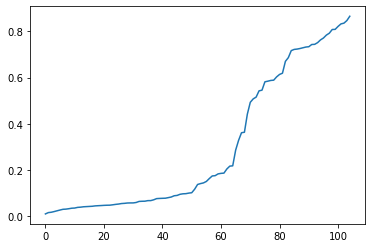

In [13]:
# Rename, listify 
# train, test, train_labels, test_labels 
actuals = list(test_labels)

# Predict probablities of test data [0,1]
scores = list(logregr.predict_proba(test)[:,1])
# scores_2 = scores
scores_full = list(logregr.predict_proba(test))

index = 2
ind2 = len(test[1])
ind22 = ind2-2

scores_2 = list(logregr.predict_proba(test)[:,ind22])

# Equivalently
import math
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))
# scores = [sigmoid(logregr.coef_@test_i + logregr.intercept_) for test_i in test]
print(len(scores))
# scores.shape
# print(scores)
# print(scores_2[104])
# print(scores_full[ind2-1])
# print(scores[index])
# print(scores[ind2-1])
# actuals
# test
# ind22
plt.plot(sorted(scores))


In [14]:
# Make Predictions with k-nearest neighbors on the Iris Flowers Dataset
from csv import reader
from math import sqrt
 
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
# 		print('[%s] => %d' % (value, i))
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Find the min and max values for each column
# def dataset_minmax(dataset):
# 	minmax = list()
# 	for i in range(len(dataset[0])):
# 		col_values = [row[i] for row in dataset]
# 		value_min = min(col_values)
# 		value_max = max(col_values)
# 		minmax.append([value_min, value_max])
# 	return minmax

# Find the min and max values for each column
def dataset_mean_std(dataset):
	mean_std = list()
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		value_mean = np.mean(col_values)
		value_std = np.std(col_values)
		mean_std.append([value_mean, value_std])
	return mean_std

# Rescale dataset columns to the range 0-1
# def normalize_dataset(dataset, minmax):
# 	for row in dataset:
# 		for i in range(len(row)):
# 			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, mean_std):
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - mean_std[i][0]) / (mean_std[i][1])
 
 
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)
 
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors
 
# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction
 
# Make a prediction with KNN on Iris Dataset
filename = 'iris.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# define model parameter
num_neighbors = 3
# define a new record
row = [4.7,7.9,3.2,0.3]
row1 = [0.7,1.5,8.4,2.0]
# predict the label
label = predict_classification(dataset, test[0].tolist(), num_neighbors)
# print('Data=%s, Predicted: %s' % (row, label))
# print(dataset)


labels1 = []
for j in range(len(test)):
    labels1.append(predict_classification(dataset, test[j], num_neighbors))
# labels
    

In [15]:
class LogisticRegressionOVR(object):
    def __init__(self, eta=0.1, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        self.w = []
        m = X.shape[0]

        for i in np.unique(y):
            y_copy = np.where(y == i, 1, 0)
#             w = np.ones(X.shape[1])
            w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

            for _ in range(self.n_iter):
                output = X.dot(w)
                errors = y_copy - self._sigmoid(output)
                w += self.eta / m * errors.dot(X)
            self.w.append((w, i))
        return self
    
#      def predict(self, X):
#         output = np.insert(X, 0, 1, axis=1).dot(self.w)
#         return (np.floor(self._sigmoid(output) + .5)).astype(int)

    def predict(self, X):
        return [self._predict_one(i) for i in np.insert(X, 0, 1, axis=1)]
    
    def _predict_one(self, x):
        return max((x.dot(w), c) for w, c in self.w)[1]

    def score(self, X, y):
        return np.sum(self.predict(X) == y) / len(y)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [16]:
logi = LogisticRegressionOVR(n_iter=1000).fit(train, train_labels)
log_sig = logi._sigmoid(test)
log_sig
logi.w
# plt.plot(log_sig)

[(array([ 1.00023881,  0.29627953,  1.92564133, -2.90270875, -1.01109027]),
  0.0),
 (array([ 1.31881842,  0.8512732 , -2.20636545,  0.14255992, -1.06879364]),
  1.0),
 (array([-0.42498545, -2.19485993, -2.03082358,  3.2961568 ,  2.68164414]),
  2.0)]

In [17]:
# Predict binary outcomes (0,1)
predictions = list(logregr.predict(test))

predictions2 = list(logi.predict(test))

# Equivalently 
# predictions = [1 if s>0.5 else 0 for s in scores]


In [18]:
print("Accuracy = %.3f" % (sum([p==a for p, a in zip(predictions2, actuals)])/len(predictions2)))

Accuracy = 0.905


In [19]:
print("Accuracy = %.3f" % (sum([p==a for p, a in zip(predictions, actuals)])/len(predictions)))

Accuracy = 0.962


In [20]:
# # print("Accuracy = %.3f" % (sum([p==a for p, a in zip(labels1, test_labels)])/len(labels1)))
# print("Accuracy = %.3f" % (sum([p==a for p, a in zip(labels1, test_labels)])/len(labels1)))

In [21]:
scored = logi._sigmoid(test_labels)
scored

array([0.73105858, 0.88079708, 0.5       , 0.5       , 0.73105858,
       0.5       , 0.88079708, 0.5       , 0.73105858, 0.73105858,
       0.88079708, 0.88079708, 0.73105858, 0.73105858, 0.88079708,
       0.73105858, 0.5       , 0.5       , 0.88079708, 0.5       ,
       0.5       , 0.5       , 0.73105858, 0.88079708, 0.73105858,
       0.88079708, 0.73105858, 0.88079708, 0.73105858, 0.73105858,
       0.5       , 0.5       , 0.73105858, 0.73105858, 0.73105858,
       0.88079708, 0.73105858, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.73105858, 0.73105858, 0.5       ,
       0.5       , 0.5       , 0.88079708, 0.88079708, 0.73105858,
       0.5       , 0.88079708, 0.88079708, 0.73105858, 0.73105858,
       0.5       , 0.5       , 0.88079708, 0.5       , 0.88079708,
       0.5       , 0.88079708, 0.73105858, 0.73105858, 0.88079708,
       0.73105858, 0.5       , 0.88079708, 0.88079708, 0.5       ,
       0.88079708, 0.73105858, 0.5       , 0.88079708, 0.88079

In [22]:
scores2 = logi.score(test,test_labels)
scores2

0.9047619047619048

In [23]:
# scores = logi.score(test,test_labels)
# scores

# scored = []
# for i in range(len(test)):
#     scored.append(logi.score(test[i],test_labels))

# scored

In [24]:
# print(labels1)
# print(actuals)

labels_pd = pd.DataFrame([actuals,labels1,predictions2])
labels_pd.T

,0,1,2
0,1.0,2.0,2.0
1,2.0,2.0,2.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,1.0,1.0
...,...,...,...
100,2.0,2.0,2.0
101,1.0,1.0,2.0
102,0.0,0.0,0.0
103,1.0,1.0,1.0


In [25]:
import collections
ConfusionMatrix = collections.namedtuple('conf', ['tp','fp','tn','fn']) 

In [26]:
def calc_ConfusionMatrix(actuals, scored, threshold=0.5, positive_label=1):
    tp=fp=tn=fn=0
    bool_actuals = [act==positive_label for act in actuals]
    for truth, score in zip(bool_actuals, scores):
        if score > threshold:                      # predicted positive 
            if truth:                              # actually positive 
                tp += 1
            else:                                  # actually negative              
                fp += 1          
        else:                                      # predicted negative 
            if not truth:                          # actually negative 
                tn += 1                          
            else:                                  # actually positive 
                fn += 1

    return ConfusionMatrix(tp, fp, tn, fn)

In [27]:
def ACC(conf_mtrx):
    return (conf_mtrx.tp + conf_mtrx.tn) / (conf_mtrx.fp + conf_mtrx.tn + conf_mtrx.tp + conf_mtrx.fn)

In [28]:
def FPR(conf_mtrx):
    return conf_mtrx.fp / (conf_mtrx.fp + conf_mtrx.tn) if (conf_mtrx.fp + conf_mtrx.tn)!=0 else 0
def TPR(conf_mtrx):
    return conf_mtrx.tp / (conf_mtrx.tp + conf_mtrx.fn) if (conf_mtrx.tp + conf_mtrx.fn)!=0 else 0

In [29]:
def apply(actuals, scores, **fxns):
    # generate thresholds over score domain 
    low = np.min(scores)
    high = np.max(scores)
    step = (abs(low) + abs(high)) / 1000
    thresholds = np.arange(low-step, high+step, step)

    # calculate confusion matrices for all thresholds
    confusionMatrices = []
    for threshold in thresholds:
        confusionMatrices.append(calc_ConfusionMatrix(actuals, scores, threshold))

    # apply functions to confusion matrices 
    results = {fname:list(map(fxn, confusionMatrices)) for fname, fxn in fxns.items()}

    results["THR"] = thresholds
    print('thresholds:',results["THR"])
    return results

In [30]:
acc = apply(actuals,scored, ACC=ACC)
acc

thresholds: [0.4986192  0.5        0.5013808  0.50276159 0.50414239 0.50552319
 0.50690399 0.50828478 0.50966558 0.51104638 0.51242717 0.51380797
 0.51518877 0.51656956 0.51795036 0.51933116 0.52071196 0.52209275
 0.52347355 0.52485435 0.52623514 0.52761594 0.52899674 0.53037754
 0.53175833 0.53313913 0.53451993 0.53590072 0.53728152 0.53866232
 0.54004312 0.54142391 0.54280471 0.54418551 0.5455663  0.5469471
 0.5483279  0.54970869 0.55108949 0.55247029 0.55385109 0.55523188
 0.55661268 0.55799348 0.55937427 0.56075507 0.56213587 0.56351667
 0.56489746 0.56627826 0.56765906 0.56903985 0.57042065 0.57180145
 0.57318225 0.57456304 0.57594384 0.57732464 0.57870543 0.58008623
 0.58146703 0.58284782 0.58422862 0.58560942 0.58699022 0.58837101
 0.58975181 0.59113261 0.5925134  0.5938942  0.595275   0.5966558
 0.59803659 0.59941739 0.60079819 0.60217898 0.60355978 0.60494058
 0.60632138 0.60770217 0.60908297 0.61046377 0.61184456 0.61322536
 0.61460616 0.61598695 0.61736775 0.61874855 0.62012

{'ACC': [0.9619047619047619,
  0.9619047619047619,
  0.9619047619047619,
  0.9619047619047619,
  0.9619047619047619,
  0.9619047619047619,
  0.9619047619047619,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9428571428571428,
  0.9333333333333333,
  0.9333333333333333,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0.9238095238095239,
  0

In [31]:
def ROC(actuals, scores):
    return apply(actuals, scores, FPR=FPR, TPR=TPR)

In [32]:
ab = ROC(actuals,scores)
# ab['FPR']

thresholds: [0.00966954 0.01054559 0.01142164 0.01229769 0.01317373 0.01404978
 0.01492583 0.01580188 0.01667792 0.01755397 0.01843002 0.01930607
 0.02018211 0.02105816 0.02193421 0.02281026 0.0236863  0.02456235
 0.0254384  0.02631445 0.0271905  0.02806654 0.02894259 0.02981864
 0.03069469 0.03157073 0.03244678 0.03332283 0.03419888 0.03507492
 0.03595097 0.03682702 0.03770307 0.03857911 0.03945516 0.04033121
 0.04120726 0.0420833  0.04295935 0.0438354  0.04471145 0.04558749
 0.04646354 0.04733959 0.04821564 0.04909169 0.04996773 0.05084378
 0.05171983 0.05259588 0.05347192 0.05434797 0.05522402 0.05610007
 0.05697611 0.05785216 0.05872821 0.05960426 0.0604803  0.06135635
 0.0622324  0.06310845 0.06398449 0.06486054 0.06573659 0.06661264
 0.06748869 0.06836473 0.06924078 0.07011683 0.07099288 0.07186892
 0.07274497 0.07362102 0.07449707 0.07537311 0.07624916 0.07712521
 0.07800126 0.0788773  0.07975335 0.0806294  0.08150545 0.08238149
 0.08325754 0.08413359 0.08500964 0.08588569 0.086

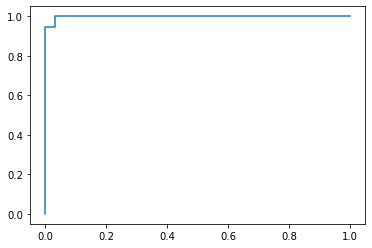

In [33]:
plt.plot(ab['FPR'],ab['TPR'])
# plt.plot(np.multiply(ab['FPR'],len(test)/6),ab['TPR'])

In [34]:
# # Declaring namedtuple()   
# Student = namedtuple('Student',['name','age','DOB'])   
      
# # Adding values   
# S = Student('Nandini','19','2541997')   
      
# # Access using index   
# print ("The Student age using index is : ",end ="")   
# print (S.DOB)   
      
# # Access using name    
# print ("The Student name using keyname is : ",end ="")   
# print (S[0]) 

In [35]:
# # Make Predictions with k-nearest neighbors on the Iris Flowers Dataset
# from csv import reader
# from math import sqrt
 
# # Load a CSV file
# def load_csv(filename):
# 	dataset = list()
# 	with open(filename, 'r') as file:
# 		csv_reader = reader(file)
# 		for row in csv_reader:
# 			if not row:
# 				continue
# 			dataset.append(row)
# 	return dataset
 
# # Convert string column to float
# def str_column_to_float(dataset, column):
# 	for row in dataset:
# 		row[column] = float(row[column].strip())
 
# # Convert string column to integer
# def str_column_to_int(dataset, column):
# 	class_values = [row[column] for row in dataset]
# 	unique = set(class_values)
# 	lookup = dict()
# 	for i, value in enumerate(unique):
# 		lookup[value] = i
# 		print('[%s] => %d' % (value, i))
# 	for row in dataset:
# 		row[column] = lookup[row[column]]
# 	return lookup
 
# # Find the min and max values for each column
# # def dataset_minmax(dataset):
# # 	minmax = list()
# # 	for i in range(len(dataset[0])):
# # 		col_values = [row[i] for row in dataset]
# # 		value_min = min(col_values)
# # 		value_max = max(col_values)
# # 		minmax.append([value_min, value_max])
# # 	return minmax

# # Find the min and max values for each column
# def dataset_mean_std(dataset):
# 	mean_std = list()
# 	for i in range(len(dataset[0])):
# 		col_values = [row[i] for row in dataset]
# 		value_mean = np.mean(col_values)
# 		value_std = np.std(col_values)
# 		mean_std.append([value_mean, value_std])
# 	return mean_std

# # Rescale dataset columns to the range 0-1
# # def normalize_dataset(dataset, minmax):
# # 	for row in dataset:
# # 		for i in range(len(row)):
# # 			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
# # Rescale dataset columns to the range 0-1
# def normalize_dataset(dataset, mean_std):
# 	for row in dataset:
# 		for i in range(len(row)):
# 			row[i] = (row[i] - mean_std[i][0]) / (mean_std[i][1])
 
 
# # Calculate the Euclidean distance between two vectors
# def euclidean_distance(row1, row2):
# 	distance = 0.0
# 	for i in range(len(row1)-1):
# 		distance += (row1[i] - row2[i])**2
# 	return sqrt(distance)
 
# # Locate the most similar neighbors
# def get_neighbors(train, test_row, num_neighbors):
# 	distances = list()
# 	for train_row in train:
# 		dist = euclidean_distance(test_row, train_row)
# 		distances.append((train_row, dist))
# 	distances.sort(key=lambda tup: tup[1])
# 	neighbors = list()
# 	for i in range(num_neighbors):
# 		neighbors.append(distances[i][0])
# 	return neighbors
 
# # Make a prediction with neighbors
# def predict_classification(train, test_row, num_neighbors):
# 	neighbors = get_neighbors(train, test_row, num_neighbors)
# 	output_values = [row[-1] for row in neighbors]
# 	prediction = max(set(output_values), key=output_values.count)
# 	return prediction
 
# # Make a prediction with KNN on Iris Dataset
# filename = 'iris.csv'
# dataset = load_csv(filename)
# for i in range(len(dataset[0])-1):
# 	str_column_to_float(dataset, i)
# # convert class column to integers
# str_column_to_int(dataset, len(dataset[0])-1)
# # define model parameter
# num_neighbors = 5
# # define a new record
# row = [4.7,7.9,3.2,0.3]
# row1 = [0.7,1.5,8.4,2.0]
# # predict the label
# label = predict_classification(dataset, row1, num_neighbors)
# print('Data=%s, Predicted: %s' % (row, label))
# # print(dataset)

In [36]:
def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def softmax2(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

ass = softmax2(test[4])
# ass[:,1]
# test_labels
test_labels[0]
print(test_labels)
ass[:3]
# test[0]

[1. 2. 0. 0. 1. 0. 2. 0. 1. 1. 2. 2. 1. 1. 2. 1. 0. 0. 2. 0. 0. 0. 1. 2.
 1. 2. 1. 2. 1. 1. 0. 0. 1. 1. 1. 2. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2.
 2. 1. 0. 2. 2. 1. 1. 0. 0. 2. 0. 2. 0. 2. 1. 1. 2. 1. 0. 2. 2. 0. 2. 1.
 0. 2. 2. 1. 1. 0. 2. 1. 1. 2. 0. 2. 2. 0. 0. 0. 2. 1. 1. 2. 0. 1. 1. 1.
 0. 2. 1. 2. 2. 1. 0. 1. 1.]


array([0.8743984 , 0.02389182, 0.0968861 ])

In [37]:
# from scipy.special import softmax
# ass = softmax(test_labels,axis=0)
# ass

In [38]:
ass = list(softmax2(test))
# print(ass)
# ass_1 = ass[:1]
# ass_1

In [39]:
# Rename, listify 
# train, test, train_labels, test_labels 
actuals = list(test_labels)

# Predict probablities of test data [0,1]
scores = list(logregr.predict_proba(test)[:,1])
# scores_2 = scores
scores_full = list(logregr.predict_proba(test))

index = 2
ind2 = len(test[1])
ind22 = ind2-2

scores_2 = list(logregr.predict_proba(test)[:,ind22])

# Equivalently
import math
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))
# scores = [sigmoid(logregr.coef_@test_i + logregr.intercept_) for test_i in test]
print(len(scores))
print(scores_2[104])
# print(scores_full[ind2-1])
# print(scores[index])
# print(scores[ind2-1])
# actuals
# test
ind22
# scores_full
# actuals

105
0.471006103650701


2

In [40]:
def _net_input(self, X):
    """Compute the linear net input."""
    return (X.dot(self.w_) + self.b_).flatten()

def _sigmoid_activation(self, z):
    """Compute the output of the logistic sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))

def _forward(self, X):
    z = self._net_input(X)
    a = self._sigmoid_activation(z)
    return a

def predict_proba(self, X):
    """Predict class probabilities of X from the net input.
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    Returns
    ----------
    Class 1 probability : float
    """
    return self._forward(X)

In [41]:
# z = test @ logi.w
abd = np.array(logi.w)
test[0]
logi.w
# z = np.matmul(test,abd)
# type(abd)
# print(test)
test.shape
logi.w

C:\Users\USER\AppData\Local\Temp/ipykernel_3948/1291536472.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abd = np.array(logi.w)


[(array([ 1.00023881,  0.29627953,  1.92564133, -2.90270875, -1.01109027]),
  0.0),
 (array([ 1.31881842,  0.8512732 , -2.20636545,  0.14255992, -1.06879364]),
  1.0),
 (array([-0.42498545, -2.19485993, -2.03082358,  3.2961568 ,  2.68164414]),
  2.0)]

In [42]:
logi.w
log_point = logi.w
log_point = log_point[0][0]
log_point_2 = log_point
log_point_2
# log_point_2
# len(X_test)
# y_test.shape
# _test.reshape(5,6)
# log_point_2.shape

array([ 1.00023881,  0.29627953,  1.92564133, -2.90270875, -1.01109027])

In [43]:
z = np.dot(test.reshape(84,5),log_point_2.reshape(5,1))
# # # type(abd)
# log_point_2.reshape(5,1)
# X_test
# logi.w_
# z
# test.shape
z

array([[ 4.33838762e+00],
       [-1.04753100e+01],
       [ 2.19594033e-01],
       [-6.35505212e+00],
       [ 6.42935706e-01],
       [-5.91262074e+00],
       [-3.28712608e-01],
       [-5.05476566e+00],
       [ 4.89291327e+00],
       [-1.15442429e+01],
       [ 2.85720872e+00],
       [-8.43244556e+00],
       [ 5.37909714e+00],
       [-1.38789390e+01],
       [-6.70521405e-01],
       [ 5.26663494e+00],
       [ 3.66127972e+00],
       [-1.64083257e+01],
       [ 2.79257180e+00],
       [-5.54231375e+00],
       [ 4.79700432e+00],
       [-1.43750011e+01],
       [ 7.08584325e+00],
       [-4.68268073e+00],
       [ 3.40563244e+00],
       [-1.57986882e+01],
       [ 4.14079284e+00],
       [-4.91518180e+00],
       [ 5.11793071e+00],
       [-1.22361632e+01],
       [-3.69804169e-02],
       [ 5.18065862e+00],
       [ 3.38958003e+00],
       [-1.83400511e+01],
       [ 4.96096808e+00],
       [ 3.77633159e+00],
       [ 3.25992820e+00],
       [-2.02124082e+01],
       [ 5.6

In [44]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))
    
h = sigmoid(z)
h

array([[9.87110737e-01],
       [2.82239901e-05],
       [5.54678959e-01],
       [1.73492940e-03],
       [6.55416779e-01],
       [2.69779049e-03],
       [4.18553898e-01],
       [6.33842942e-03],
       [9.92556282e-01],
       [9.69158514e-06],
       [9.45690116e-01],
       [2.17641090e-04],
       [9.95409189e-01],
       [9.38540425e-07],
       [3.38380099e-01],
       [9.94865550e-01],
       [9.74944318e-01],
       [7.48091419e-08],
       [9.42273096e-01],
       [3.90216578e-03],
       [9.91813140e-01],
       [5.71499842e-07],
       [9.99163831e-01],
       [9.16931819e-03],
       [9.67880100e-01],
       [1.37631183e-07],
       [9.84338939e-01],
       [7.28098285e-03],
       [9.94047246e-01],
       [4.85176463e-06],
       [4.90755949e-01],
       [9.94407155e-01],
       [9.67377294e-01],
       [1.08396939e-08],
       [9.93042602e-01],
       [9.77606393e-01],
       [9.63028234e-01],
       [1.66672007e-09],
       [9.96440858e-01],
       [1.48599604e-02],


In [45]:
sorted(h)

[array([1.51112151e-09]),
 array([1.66672007e-09]),
 array([1.08396939e-08]),
 array([3.93160538e-08]),
 array([7.48091419e-08]),
 array([1.37631183e-07]),
 array([2.00092551e-07]),
 array([4.34054597e-07]),
 array([4.79108365e-07]),
 array([5.71499842e-07]),
 array([5.8630189e-07]),
 array([9.38540425e-07]),
 array([1.19055206e-06]),
 array([4.85176463e-06]),
 array([9.69158514e-06]),
 array([1.8954102e-05]),
 array([2.41308317e-05]),
 array([2.82239901e-05]),
 array([3.30091605e-05]),
 array([3.54165291e-05]),
 array([3.93402493e-05]),
 array([4.66273328e-05]),
 array([8.45217575e-05]),
 array([0.0001199]),
 array([0.00021764]),
 array([0.0009126]),
 array([0.00173493]),
 array([0.00246842]),
 array([0.00260247]),
 array([0.00269779]),
 array([0.00390217]),
 array([0.00633843]),
 array([0.00643965]),
 array([0.00728098]),
 array([0.00916932]),
 array([0.01485996]),
 array([0.01934623]),
 array([0.03840768]),
 array([0.3383801]),
 array([0.34554105]),
 array([0.4185539]),
 array([0.42

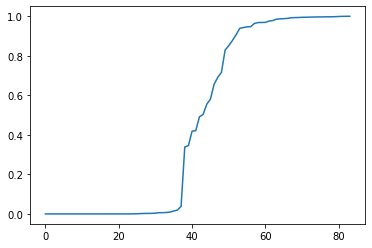

In [46]:
plt.plot(sorted(h))

In [47]:
logi.w
log_point = logi.w
log_point = log_point[0][0]
log_point_2 = log_point
log_point_2


z = np.dot(test.reshape(84,5),log_point_2.reshape(5,1))
# print(z)

h1 = sigmoid(z)
# h1
# print(test_labels)
# print(test_labels)

In [48]:
ab = ROC(actuals,sorted(h1))

thresholds: [-9.99350990e-04  1.51112151e-09  9.99354012e-04 ...  9.97353797e-01
  9.98353150e-01  9.99352502e-01]


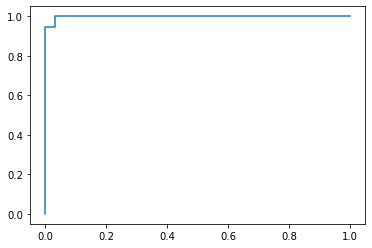

In [49]:
plt.plot(ab['FPR'],ab['TPR'])

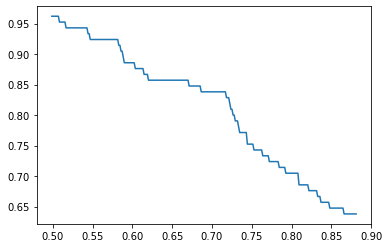

In [50]:
# acc
plt.plot(acc['THR'],acc['ACC'])


thresholds: [-9.99350990e-04  1.51112151e-09  9.99354012e-04 ...  9.97353797e-01
  9.98353150e-01  9.99352502e-01]


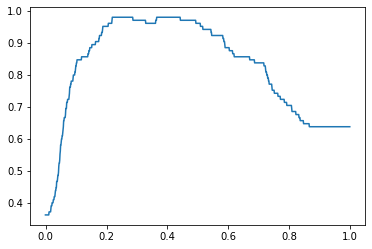

In [51]:
acc = apply(actuals,sorted(h), ACC=ACC)
plt.plot(acc['THR'],acc['ACC'])